In [35]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
from scipy import stats
import string
import re
from difflib import SequenceMatcher as SM

# ignore annoying warnings
warnings.filterwarnings('ignore')

NameError: name 'warnings' is not defined

# Background
In this homework we will extract interesting information from www.topuniversities.com and www.timeshighereducation.com, two platforms that maintain a global ranking of worldwide universities. This ranking is not offered as a downloadable dataset, so we had to find a way to scrape the information.

To understand how the server loads the data in the browser, we used Postman with the Interceptor extension.

## Task 1: Obtain the 200 top-ranking universities in www.topuniversities.com.

Required fields: name, rank, country and region, number of faculty members (international and total) and number of students (international and total)

In order to get the data, we ran Postman (+ Interceptor), and accessed topuniversities.com from a browser. Then, we observed the different queries that were emitted by this visit, and isolated the query (url) that fetched the data. This query returns a JSON file, that we processed with BeautifulSoup in order to extract the required data and store it in a Pandas DataFrame.

Some information (total and international faculty members/students are not directly available from the main page (the page that dispays the ranking). Thus, for each university, we had to get this data from its details page. The function *get_details* extracts these fields from the details page given in parameter.

We could not get a JSON containing the data from the *details* pages, so we had to use BeautifulSoup to directly extract data from the html body.

In [2]:
# input: link to the university details page where we can find the detail numbers
# returns an array as follows: [total_academic_fac_staff, inter_academic_fac_staff, total_students, inter_students]
def get_details(link):
    link = link + '#wurs'
    r = requests.get(link)
    page_body = r.text
    soup = BeautifulSoup(page_body, 'html.parser')
    
    # will contain total_academic_fac_staff, inter_academic_fac_staff, total_students, inter_students
    results = []
    for name in ['total faculty', 'inter faculty', 'total student', 'total inter']:
        try:
            elem = np.int(soup.find('div', class_= name).find('div', class_='number').text.replace(',',''))
        except AttributeError:
            elem = None
        results.append(elem)
    return results

In [3]:
# send a request to get the content of the ranking list
# We found the correct url where to send the request using postman and checking the different requests that were sent
r = requests.get('https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt')
json_data = r.json()
cols = ['QSrank', 'region', 'country', 'Faculty members (total)', 'Faculty members (inter.)', 'Students (total)', 'Students (inter.)']
df_QS = pd.DataFrame(columns=cols)


# for each univerity in the list, get basic attributes and try to get the details
# We had to discard one university with the above ranking check. Thus we also take the 201th university to have the actual top-200
for i, uni in enumerate(json_data['data'][:201]):
    soup = BeautifulSoup(uni['uni'], 'html.parser')
    details_link = 'https://www.topuniversities.com' + soup.a['href']
    name = soup.a.string
    country = uni['location']
    region = uni['region']
    rank = np.int(uni['overall_rank'])
    details = get_details(details_link)
    # we saw that for some reason the uni ranked 281 appeared in the top-200.
    # this check avoids having it in our ranking
    if int(rank) <= 201:
        df_QS.loc[name] = ([rank, region, country] + details)
    print("Progression: " + '{0:.1f}'.format(100*(i+1)/201.0) + "%", end="\r")
#print("Progression: Done!", end="\r")

In [4]:
df_QS.head(10)

,QSrank,region,country,Faculty members (total),Faculty members (inter.),Students (total),Students (inter.)
Massachusetts Institute of Technology (MIT),1,North America,United States,2982,1679,11067,3717
Stanford University,2,North America,United States,4285,2042,15878,3611
Harvard University,3,North America,United States,4350,1311,22429,5266
California Institute of Technology (Caltech),4,North America,United States,953,350,2255,647
University of Cambridge,5,Europe,United Kingdom,5490,2278,18770,6699
University of Oxford,6,Europe,United Kingdom,6750,2964,19720,7353
UCL (University College London),7,Europe,United Kingdom,6345,2554,31080,14854
Imperial College London,8,Europe,United Kingdom,3930,2071,16090,8746
University of Chicago,9,North America,United States,2449,635,13557,3379
ETH Zurich - Swiss Federal Institute of Technology,10,Europe,Switzerland,2477,1886,19815,7563


### Task 1.2: Which are the best universities in terms of:

#### (a) Ratio between faculty members and students

In order to compute this ratio, we divided the number of total students by the number of total faculty members. This way, we know how much students there is for one faculty member by universities. It is obvious that the less students per faculty member the better, therefore we sort this ratio in ascending order. 

In [5]:
#Top 10 universities with the largest fac members/students ratio
df_QS['Students/Fac members'] = (df_QS['Students (total)']/df_QS['Faculty members (total)']).astype(float)
resultfirstratio = df_QS.sort_values('Students/Fac members' , ascending = True )
print('The average of the ratio is ' + str(resultfirstratio['Students/Fac members'].mean()))
resultfirstratio.head(10)

The average of the ratio is 9.60803721295883


,QSrank,region,country,Faculty members (total),Faculty members (inter.),Students (total),Students (inter.),Students/Fac members
California Institute of Technology (Caltech),4,North America,United States,953,350,2255,647,2.366212
Yale University,16,North America,United States,4940,1708,12402,2469,2.510526
University of Oxford,6,Europe,United Kingdom,6750,2964,19720,7353,2.921481
University of Cambridge,5,Europe,United Kingdom,5490,2278,18770,6699,3.418944
Johns Hopkins University,17,North America,United States,4462,1061,16146,4105,3.618557
Stanford University,2,North America,United States,4285,2042,15878,3611,3.705484
Massachusetts Institute of Technology (MIT),1,North America,United States,2982,1679,11067,3717,3.711268
University of Rochester,186,North America,United States,2569,488,9636,2805,3.750876
University of Pennsylvania,19,North America,United States,5499,1383,20639,4250,3.753228
Columbia University,18,North America,United States,6189,913,25045,8105,4.046696


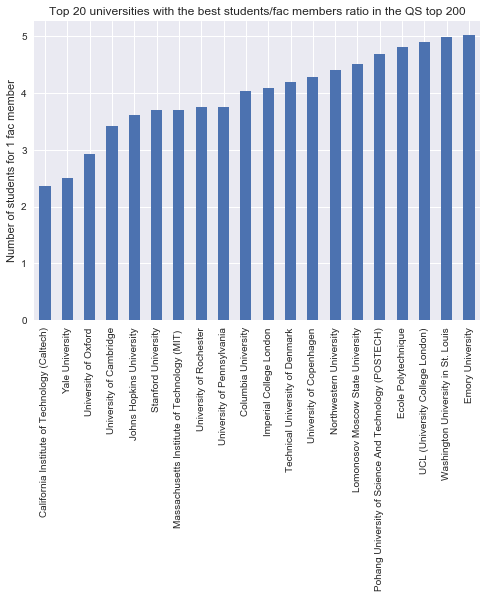

In [6]:
#Let's plot the top20 , we are simply barploting a Pandas Serie.
resultfirstratio['Students/Fac members'].head(20).plot(kind = 'bar')
plt.title('Top 20 universities with the best students/fac members ratio in the QS top 200')
plt.ylabel('Number of students for 1 fac member')

Caltech is the university with the best ratio with only 2.4 students per faculty member and the average of this ratio for the top 200 is of 9.6 students per faculty member. Note that the 10 universities with the best ratio are from the US or the UK. Furthermore, all of these but the university of Rochester are in the top 20 of the general QS ranking. This leads us to suspect that there is a correlation between this ratio and the QS ranking. We will investigate this correlations in the part 4 of the homework.

#### (b) Ratio of international students

In this part we are asked to compute the ratio of international students. We simply divide the number of total students by the number of international students in order to have the ratio of international students by universities.

In [7]:
#Top 10 universities with the largest international students ratio
df_QS['International students ratio'] = (df_QS['Students (inter.)']/df_QS['Students (total)']).astype(float)
resultsecondratio = df_QS.sort_values('International students ratio' , ascending = False )
print('The average of the ratio is ' + str(resultsecondratio['International students ratio'].mean()))
resultsecondratio.head(10)

The average of the ratio is 0.2107532059064776


,QSrank,region,country,Faculty members (total),Faculty members (inter.),Students (total),Students (inter.),Students/Fac members,International students ratio
London School of Economics and Political Science (LSE),35,Europe,United Kingdom,1088,687,9760,6748,8.970588,0.691393
Ecole Polytechnique Fédérale de Lausanne (EPFL),12,Europe,Switzerland,1695,1300,10343,5896,6.102065,0.570047
Imperial College London,8,Europe,United Kingdom,3930,2071,16090,8746,4.094148,0.543567
Maastricht University,200,Europe,Netherlands,1277,502,16385,8234,12.830854,0.502533
Carnegie Mellon University,47,North America,United States,1342,425,13356,6385,9.952310,0.478062
UCL (University College London),7,Europe,United Kingdom,6345,2554,31080,14854,4.898345,0.477928
University of St Andrews,92,Europe,United Kingdom,1140,485,8800,4030,7.719298,0.457955
The University of Melbourne,41,Oceania,Australia,3311,1477,42182,18030,12.739958,0.427434
Queen Mary University of London,127,Europe,United Kingdom,1885,801,16135,6806,8.559682,0.421816
The University of Hong Kong,26,Asia,Hong Kong,3012,2085,20214,8230,6.711155,0.407144


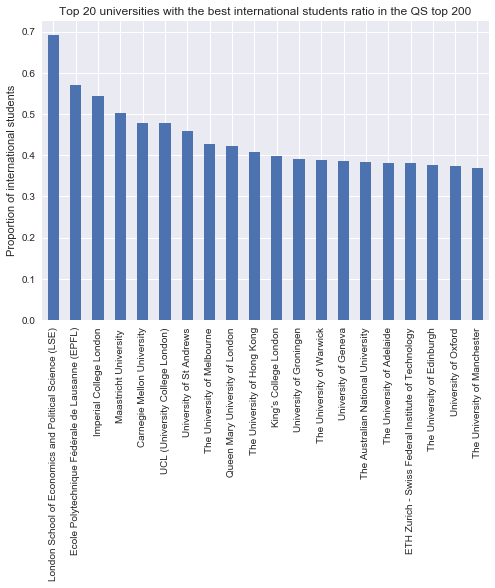

In [8]:
resultsecondratio['International students ratio'].head(20).plot(kind = 'bar')
plt.title('Top 20 universities with the best international students ratio in the QS top 200')
plt.ylabel('Proportion of international students')

The university with the greater percentage of international students is LSE (69%). Note that EPFL is second with 57%. The average across the QS top 200 is 21%. Note that there is only one university from North America in the top 10 of this ratio. Furthermore, this ratio seems to be less correlated with the golbal QS ranking than the previous one. Indeed, the 200th university (so the worst one we scraped) has the 4th best ratio. Again, we will investigate the correlations in more details later on.

### Task 1.3: Answer the previous question aggregating the data by:

TODO: *Describe briefly what you observe*

#### (c) country

Compute the ratio between faculty members and students per country:

The method for the computation of this ratio is to group the universities by country and then compute the sum of the faculty members and the sum of the students separately. Then, we divide the sum of number of students by the sum of the faculty numbers in order to have the number of students per faculty member in the country (remember that we only consider the univerties that are in the top 200 in the QS general ranking). We will present our results with the help of a barplot.

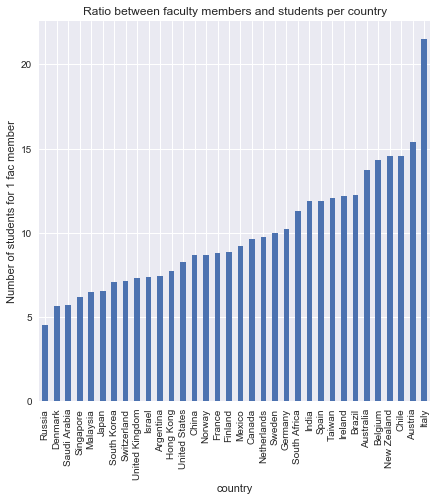

In [9]:
#Compute the ratio between faculty members and students per country
Country_facmembers = df_QS.groupby('country')['Faculty members (total)'].sum()
Country_students = df_QS.groupby('country')['Students (total)'].sum()
plt.figure(figsize=[7,7])
Country_students.div(Country_facmembers).sort_values(ascending=True).plot(kind = 'bar')
plt.title('Ratio between faculty members and students per country')
plt.ylabel('Number of students for 1 fac member')

Russia is the country with the best ratio with less that 5 students per faculty member. The worst one is Italy with more than 20 students per faculty member. The countries with the best univerties (US, UK, Switzerland) are ranked quite high.

Compute the ratio of international students per country:

The computation method is the same as above. We group by country and then sum the total number of students and the number of international students. Then we devide these sums in order to have the ratio of international students per country

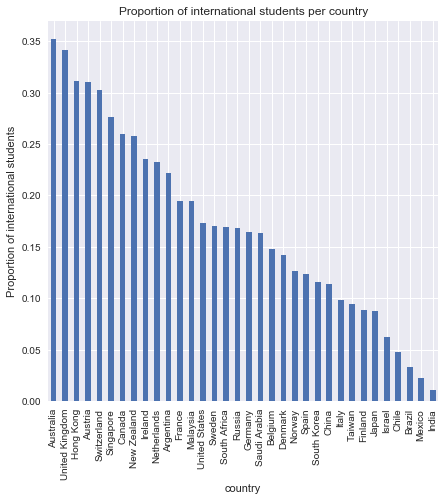

In [10]:
#Compute the ratio of international students per country
Country_intstudents = df_QS.groupby('country')['Students (inter.)'].sum()
plt.figure(figsize=[7,7])
Country_intstudents.div(Country_students).sort_values(ascending=False).plot(kind = 'bar')
plt.title('Proportion of international students per country')
plt.ylabel('Proportion of international students')

Australia is at the top with a ratio of 0.35. We notice that the least 'attractive' countries are emerging countries whereas the most 'attractive' ones are known for being 'rich' countries.

#### (d) region

Compute the ratio between faculty members and students per region:

The method is the same as the one with the countries but we group by regions instead.

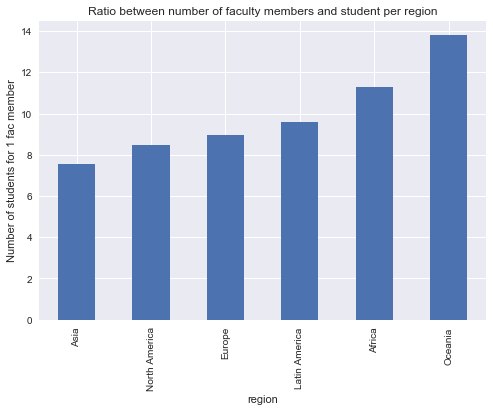

In [11]:
#Compute the ratio between faculty members and students per region
Region_facmembers = df_QS.groupby('region')['Faculty members (total)'].sum()
Region_students = df_QS.groupby('region')['Students (total)'].sum()
Region_students.div(Region_facmembers).sort_values(ascending=True).plot(kind = 'bar')
plt.title('Ratio between number of faculty members and student per region')
plt.ylabel('Number of students for 1 fac member')

Asia is the region that has the best students/faculty member ratio. Oceania has the worst ratio with almost two times more students per faculty member compared to Asia.

Compute the ratio of international students per region:

The method is the same as the one with the countries but we group by regions instead.

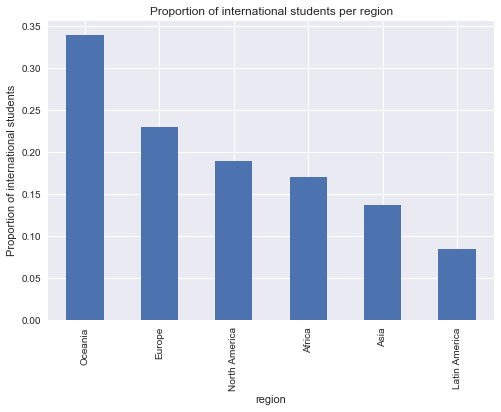

In [12]:
#Compute the ratio of international students per region
Region_intstudents = df_QS.groupby('region')['Students (inter.)'].sum()
Region_intstudents.div(Region_students).sort_values(ascending=False).plot(kind = 'bar')
plt.title('Proportion of international students per region')
plt.ylabel('Proportion of international students')

Oceania is the region with the greatest part of international students. When looking at the group by country results, we notice that this is mainly thanks to Australia and New-Zealand. Europe comes second. Latin America has the worst ratio. These results are consistents with the ones we had for the analysis by countries.

## Task 2: Obtain the 200 top-ranking universities in www.timeshighereducation.com (ranking 2018). 
### Repeat the analysis of the previous point and discuss briefly what you observed.


In order to scrape the data from the *Times Higher Education* ranking, we proceeded the same way as for the *QS* ranking.

The number of international students and staff members is not given on this website, though we get the ratios compared with the number of students. Hence, we will create the 'Students (inter.)' and 'Faculty members (total)' by calculations.

In [13]:
# Execute the request and get the data in JSON format
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
json_data = r.json()

In [14]:
cols = ['THrank',  'country', 'Students (total)', 'Students (inter.)','International students ratio', 'Students/Fac members' ,'Faculty members (total)',]
df_TH = pd.DataFrame(columns=cols)

# for each univerity in the list, get basic attributes and try to get the details
for i, uni in enumerate(json_data['data'][:200]):
    name = uni['name']
    country = uni['location']
    THrank = np.int((uni['rank'].replace('=','')))
    students_tot = np.int(uni['stats_number_students'].replace(',',''))
    student_int_ratio = np.float(uni['stats_pc_intl_students'][:-1])/100
    student_staff_ratio = np.float(uni['stats_student_staff_ratio'])
    staff_number = np.int(students_tot/student_staff_ratio)
    int_student = np.int(students_tot*student_int_ratio)
    
    df_TH.loc[name] = ([THrank, country, students_tot, int_student, student_int_ratio, student_staff_ratio,staff_number])
    print("Progression: " + '{0:.1f}'.format(100*(i+1)/200.0) + "%", end="\r")

Let's take a look at the data we just scraped:

In [15]:
df_TH.head()

,THrank,country,Students (total),Students (inter.),International students ratio,Students/Fac members,Faculty members (total)
University of Oxford,1,United Kingdom,20409,7755,0.38,11.2,1822
University of Cambridge,2,United Kingdom,18389,6436,0.35,10.9,1687
California Institute of Technology,3,United States,2209,596,0.27,6.5,339
Stanford University,3,United States,15845,3485,0.22,7.5,2112
Massachusetts Institute of Technology,5,United States,11177,3800,0.34,8.7,1284


The region not being present in the dataframe, we use the link between country and region from the QS dataframe to create the new column.

In [16]:
dico = dict(zip(df_QS['country'].values, df_QS['region'].values))
df_TH['region'] = df_TH['country'].replace(dico)
df_TH['region'].unique()

array(['Europe', 'North America', 'Asia', 'Oceania', 'Africa',
       'Luxembourg', 'Russian Federation'], dtype=object)

Luxembourg and Russian federation are not in the dictionnary, hence it created some mistakes in the new region column. We will set the Luxembourg and Russian federation to Europe

In [17]:
df_TH.loc[df_TH['region']=='Luxembourg', 'region'] = 'Europe'
df_TH.loc[df_TH['region']=='Russian Federation', 'region'] = 'Europe'
#Let's rearrange the columns a bit
df_TH = df_TH[['THrank' , 'region' , 'country' , 'Faculty members (total)' , 'Students (total)' , 'Students (inter.)', 'Students/Fac members' , 'International students ratio' ]]
df_TH.head(10)

,THrank,region,country,Faculty members (total),Students (total),Students (inter.),Students/Fac members,International students ratio
University of Oxford,1,Europe,United Kingdom,1822,20409,7755,11.2,0.38
University of Cambridge,2,Europe,United Kingdom,1687,18389,6436,10.9,0.35
California Institute of Technology,3,North America,United States,339,2209,596,6.5,0.27
Stanford University,3,North America,United States,2112,15845,3485,7.5,0.22
Massachusetts Institute of Technology,5,North America,United States,1284,11177,3800,8.7,0.34
Harvard University,6,North America,United States,2283,20326,5284,8.9,0.26
Princeton University,7,North America,United States,958,7955,1909,8.3,0.24
Imperial College London,8,Europe,United Kingdom,1390,15857,8721,11.4,0.55
University of Chicago,9,North America,United States,2181,13525,3381,6.2,0.25
ETH Zurich – Swiss Federal Institute of Technology Zurich,10,Europe,Switzerland,1317,19233,7308,14.6,0.38


### Task 2.2: Which are the best universities in terms of:

#### (a) Ratio between faculty members and students

Here we don't have to calculate the ratios as they are already in our dataframe, we will simply reorder our dataframe using the dedicated columns.

In [18]:
#Top 10 universities with the largest fac members/students ratio
resultfirstratio = df_TH.sort_values('Students/Fac members' , ascending = True )
resultfirstratio.head(10)

,THrank,region,country,Faculty members (total),Students (total),Students (inter.),Students/Fac members,International students ratio
Vanderbilt University,105,North America,United States,3639,12011,1561,3.3,0.13
University of Copenhagen,109,Europe,Denmark,7413,30395,4255,4.1,0.14
Johns Hopkins University,13,North America,United States,3604,15498,3719,4.3,0.24
Yale University,12,North America,United States,2826,12155,2552,4.3,0.21
University of Rochester,153,North America,United States,2240,9636,2794,4.3,0.29
Emory University,98,North America,United States,2874,12649,2403,4.4,0.19
Duke University,17,North America,United States,3390,15256,3356,4.5,0.22
École Polytechnique,115,Europe,France,548,2799,1007,5.1,0.36
Scuola Normale Superiore di Pisa,184,Europe,Italy,99,515,36,5.2,0.07
University of Pittsburgh,100,North America,United States,4468,26367,2636,5.9,0.10


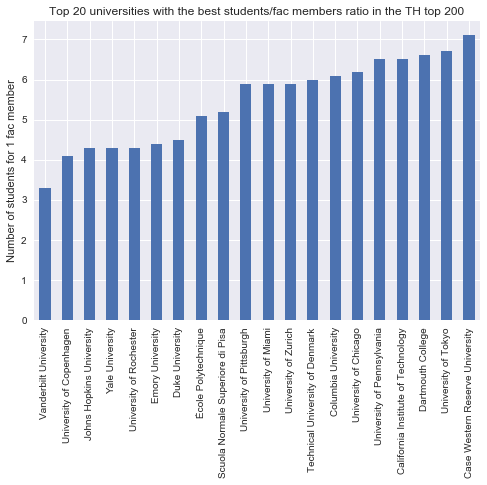

In [19]:
resultfirstratio['Students/Fac members'].head(20).plot(kind = 'bar')
plt.title('Top 20 universities with the best students/fac members ratio in the TH top 200')
plt.ylabel('Number of students for 1 fac member')

Our first observation here is that the TH ranking has much higher ratios than the QS ranking. Here the first university has a ratio of 3.3 students per staff member while the first one had 2.36 students per staff members. John Hopkins and Yale having a ratio of 4.3 in TH were leveled at 3.6 and 2.5 respectively in the QS ranking. While only british or american universities were in the top 10 in the QS ranking, here a few european universities appear in the ranking. 

#### (b) Ratio of international students

In [20]:
#Top 10 universities with the largest international students ratio
resultsecondratio = df_TH.sort_values('International students ratio' , ascending = False )
resultsecondratio.head(10)

,THrank,region,country,Faculty members (total),Students (total),Students (inter.),Students/Fac members,International students ratio
London School of Economics and Political Science,25,Europe,United Kingdom,825,10065,7146,12.2,0.71
University of Luxembourg,179,Europe,Luxembourg,340,4969,2832,14.6,0.57
École Polytechnique Fédérale de Lausanne,38,Europe,Switzerland,886,9928,5460,11.2,0.55
Imperial College London,8,Europe,United Kingdom,1390,15857,8721,11.4,0.55
Maastricht University,103,Europe,Netherlands,929,16727,8363,18.0,0.50
University College London,16,Europe,United Kingdom,2886,30304,14848,10.5,0.49
University of St Andrews,143,Europe,United Kingdom,692,9005,4322,13.0,0.48
Carnegie Mellon University,24,North America,United States,938,12676,5704,13.5,0.45
Queen Mary University of London,121,Europe,United Kingdom,1158,15405,6932,13.3,0.45
University of Hong Kong,40,Asia,Hong Kong,1020,18364,7712,18.0,0.42


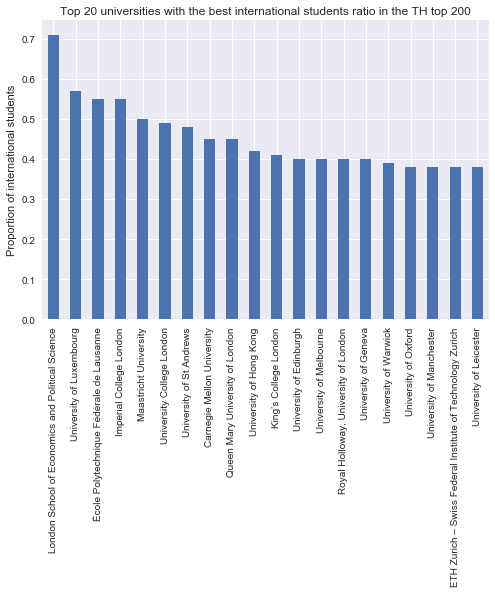

In [21]:
resultsecondratio['International students ratio'].head(20).plot(kind = 'bar')
plt.title('Top 20 universities with the best international students ratio in the TH top 200')
plt.ylabel('Proportion of international students')

This ranking is very consistent with the QS ranking. Only the apparition of the university of Luxembourg and the switch of ranks between UCL, Carnegie Melon and Saint Andrews differentiate the rankings.
### Task 2.3: Answer the previous question aggregating the data by:

#### (c) country
As explained above, here we group the universities by their country and sum their number of students and facultx members before applying the ratio.

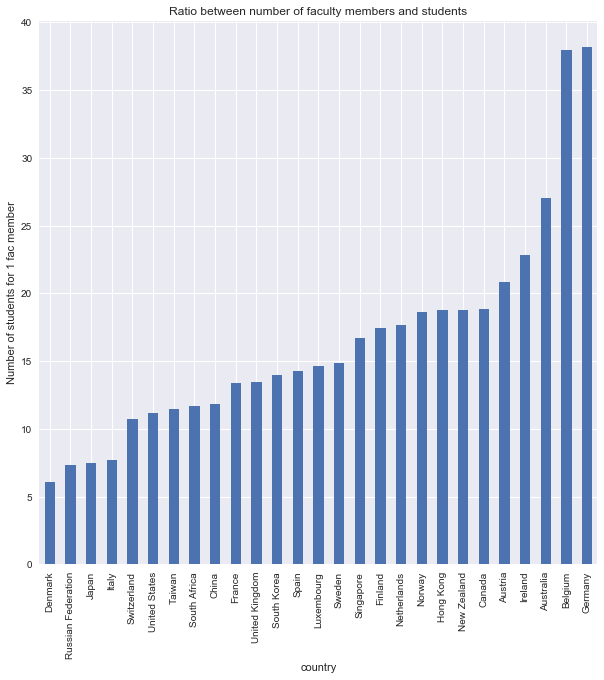

In [22]:
#Compute the ratio between faculty members and students per country
Country_facmembers = df_TH.groupby('country')['Faculty members (total)'].sum()
Country_students = df_TH.groupby('country')['Students (total)'].sum()
plt.figure(figsize=[10,10])
Country_students.div(Country_facmembers).sort_values(ascending=True).plot(kind = 'bar')
plt.title('Ratio between number of faculty members and students')
plt.ylabel('Number of students for 1 fac member')

The main difference that we have discovered here is the ranking of Italy (4th in TH, 20th in QS). Denmark and Russian federation are switched compared to the QS ranking but we see a bit of consistency here between the two rankings.

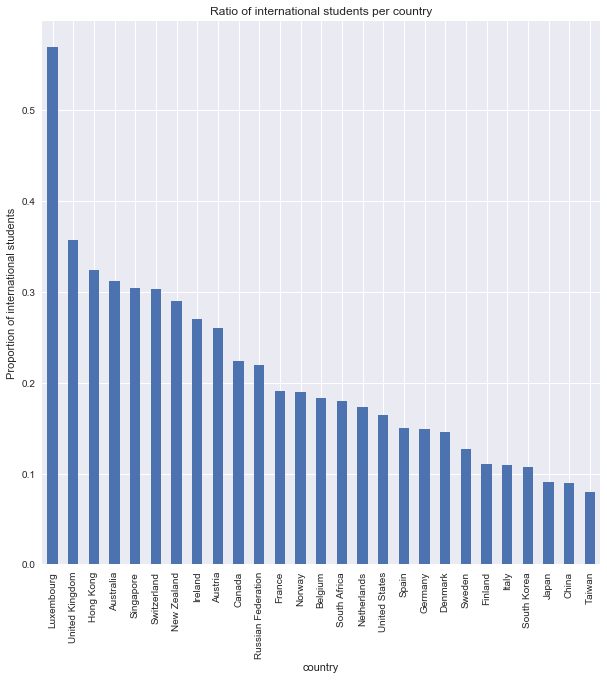

In [23]:
#Compute the ratio of international students per country
Country_intstudents = df_TH.groupby('country')['Students (inter.)'].sum()
plt.figure(figsize=[10,10])
Country_intstudents.div(Country_students).sort_values(ascending=False).plot(kind = 'bar')
plt.title('Ratio of international students per country')
plt.ylabel('Proportion of international students')

The apparition of Luxembourg in this ranking comes from the fact that this country is represented by only one university and it is not present in the QS ranking. Overall again, we see consistency between the rankings.

#### (d) region

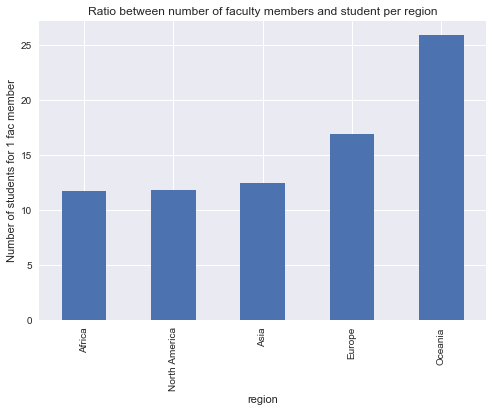

In [24]:
#Compute the ratio between faculty members and students per region
Region_facmembers = df_TH.groupby('region')['Faculty members (total)'].sum()
Region_students = df_TH.groupby('region')['Students (total)'].sum()
Region_students.div(Region_facmembers).sort_values(ascending=True).plot(kind = 'bar')
plt.title('Ratio between number of faculty members and student per region')
plt.ylabel('Number of students for 1 fac member')

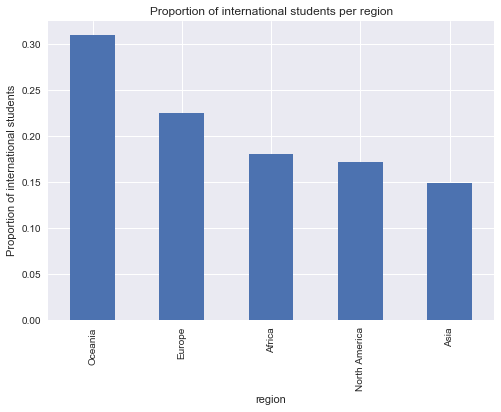

In [25]:
#Compute the ratio of international students per region
Region_intstudents = df_TH.groupby('region')['Students (inter.)'].sum()
Region_intstudents.div(Region_students).sort_values(ascending=False).plot(kind = 'bar')
plt.title('Proportion of international students per region')
plt.ylabel('Proportion of international students')

## Observations : 
The rankings by region are consistent with the QS ranking. As we summ up the values by regions, the differences by universities gets meaned by our calculations and guide QS and TH to have approximately the same results by region. 

## Task 3: Merging the two DataFrames
Merge the two DataFrames created in questions 1 and 2 using university names. Match universities' names as well as you can, and explain your strategy. Keep track of the original position in both rankings.

### Overview
The challenge here is to match the universities from the QS and TH rankings, because for a single university, its name can differ from one ranking to the other. However, in most cases the name is the same in both rankings, or is only slightly different. Here are some examples of differences that occur the most:
- the acronym of the university appears at the end of the name in parenthesis 
    - *example: Ecole Polytechnique Federale de Lausanne **(EPFL)***
- Capital letters, accents
    - *example:* ecole/école/Ecole/École
- Some non-alphanumeric characters are not the same
    - *example:* ' vs \` vs ’ *or* - vs —
- Some translation issues:
    - *example:* University/Universiteit/Université/..., of/zu/de/...
- Some additional linking words:
    - *example: * **The** university **of** [...] / University [...]

### String matching algorithm

Here, we detail step by step the process that we followed to match the university names of the two rankings:
1. Store all names of QS (resp. TH) into a Python set named *a* (resp. *b*)
2. Create a Python dictionary *(matchings)*, and for each element of *a* create a key in *matchings* with value *None*
3. Iterate a first time over each element in b, and
    1. Check if it matches perfectly some element in a (basic string comparision)
    2. Check if the cleaned version of *elem_B* matches a cleaned elem from *a* *(See function clean_string below)*
    1. It there's a match, remove *elem_B* from *b* and set *matchings*[*elem_A*]* -> elem_B*
    2. At this point, 141 elements are already matched
4. For the remaining elements that our algorithm may havec missed, we used the *SequenceMatcher* class from Python's *difflib* module, which implements an improved version of Ratcliff and Obershelp's *Gestalt pattern matching* algorithm, which basically looks for the longest common contiguous sequence of characters with no junk in it between two strings. For more information, see *John W. Ratcliff and David Metzener, Pattern Matching: The Gestalt Approach, Dr. Dobb's Journal, page 46, July 1988*. For more information about *difflib*, see *https://docs.python.org/2/library/difflib.html*

    Basically we use the method *ratio()*, which computes a coefficient of similarity between two strings using the method described above. Among the remaining elements to match, we keep the pairs with the highest coefficients. The coefficient varies between 0 and 1. We set a threshold that defines the minimum coefficient needed to consider that it's a match. We tweaked the ratio to get the best possible results.
    
In total, 153 universities out of 200 are matched. The remaining 47 are universities that appear in one ranking, but not the other.

In [26]:
# elem: The string that we want to clean
# pattern: a regexp pattern of the type of words we wish to clean/tokenize from the names
# returns a version of the string cleaned of all the words/characters that
# do not give any information about the uni and can make it differ from its matching
def clean_string(elem, pattern):
    # replace - by space
    clean_elem = re.sub('[–-]', ' ', elem)
    # remove all that is inside parenthesis (if it's at least 5 characters)
    clean_elem = re.sub(r'\(.{0,5}?\)', '', clean_elem)
    # to lowercase
    clean_elem = clean_elem.lower()
    # remove accents
    clean_elem = re.sub('[\é\è]', 'e', clean_elem)
    clean_elem = re.sub('[ä]', 'a', clean_elem)
    clean_elem = re.sub('[ü]', 'u', clean_elem)
    clean_elem = re.sub('[ö]', 'o', clean_elem)
    # remove all punctuation
    clean_elem = "".join([c for c in clean_elem if c in string.ascii_letters or c in string.whitespace])
    # remove all linking words that are not useful to disinguish universities and can cause issues
    words = [x for x in clean_elem.split() if re.match(pattern, x) is None]
    clean_elem = ' '.join(words)
    # if a space remains at the end of the string, remove it. Also remove double spaces
    clean_elem = re.sub('[ ]{2,}', ' ', clean_elem)
    if clean_elem[-1] == ' ':
        clean_elem = clean_elem[:-1]
    return clean_elem

First, check perfect matchings and "cleaned matchings":

In [27]:
# creating the two lists and a dictionary for the matchings
a = df_QS.index.values.tolist()
b = df_TH.index.values.tolist()
matchings = dict()
for elem in a:
    matchings[elem] = None

# The words that we want to get rid of when we clean the name
pattern = r'[uU]niversit(y|at|aet|eit)|(\bof\b)|\b([tT]he)\b|(\bzu\b)|(\bat\b)'

# first match and extract all perfect matchings and names that match after cleaning them
for elemA in a:
    for elemB in b.copy():
        if elemA == elemB or clean_string(elemA, pattern) == clean_string(elemB, pattern):
            matchings[elemA] = elemB
            b.remove(elemB)
print(str(200 - len(b)) + ' elements out of 200 are matched')

141 elements out of 200 are matched


Then, perform fuzzy string comparison for the remaining elements:

In [28]:
# fuzzy matching
threshold = 0.67
# loop over TH university names
for elemB in b.copy():
    max_ratio = 0
    best_match = None
    # check for the name in the QS directory that matches the best elemB if it exists
    for elemA in a:
        match_ratio = SM(None, clean_string(elemA, pattern), clean_string(elemB, pattern)).ratio()
        if match_ratio > threshold and match_ratio > max_ratio and matchings[elemA] is None:
            max_ratio = match_ratio
            best_match = elemA
    # if a match has been found save the index in matchings dictionary
    if best_match is not None:
        matchings[best_match] = elemB
        b.remove(elemB)
        #print(best_match + " -> " + elemB + " " + str(int(max_ratio*100)))

print(str(200 - len(b)) + ' elements out of 200 are matched')
        

153 elements out of 200 are matched


In [29]:
# add remaining universities to the dictionary
for elemB in b:
    matchings[elemB] = None

Print all the matchings to get an insight of the correctness of the algorithm. As we can see, it seems to work pretty well:

In [30]:
for key in matchings:
    print(key)
    print(str(matchings[key]))
    print()

Massachusetts Institute of Technology (MIT) 
Massachusetts Institute of Technology

Stanford University
Stanford University

Harvard University
Harvard University

California Institute of Technology (Caltech)
California Institute of Technology

University of Cambridge
University of Cambridge

University of Oxford
University of Oxford

UCL (University College London)
University College London

Imperial College London
Imperial College London

University of Chicago
University of Chicago

ETH Zurich - Swiss Federal Institute of Technology
ETH Zurich – Swiss Federal Institute of Technology Zurich

Nanyang Technological University, Singapore (NTU)
Nanyang Technological University, Singapore

Ecole Polytechnique Fédérale de Lausanne (EPFL)
École Polytechnique Fédérale de Lausanne

Princeton University
Princeton University

Cornell University
Cornell University

National University of Singapore (NUS)
National University of Singapore

Yale University
Yale University

Johns Hopkins University
Jo

At this point, we have a dictionnary *name A* -> *name B*. We will now use it to merge the dataframes

In [31]:
# merge the two dataframes with the matchings dictionnary
matchings_no_none = {k:v for k,v in matchings.items() if v is not None}
merged_df = df_QS.copy()
merged_df.index = merged_df.index.to_series().replace(matchings_no_none)
merged_df = pd.merge(merged_df, df_TH, left_index=True, right_index=True, how='outer', suffixes=['_QS', '_TH'])
merged_df

,QSrank,region_QS,country_QS,Faculty members (total)_QS,Faculty members (inter.),Students (total)_QS,Students (inter.)_QS,Students/Fac members_QS,International students ratio_QS,THrank,region_TH,country_TH,Faculty members (total)_TH,Students (total)_TH,Students (inter.)_TH,Students/Fac members_TH,International students ratio_TH
Aalto University,137,Europe,Finland,1257,370,12147,1831,9.663484,0.150737,190,Europe,Finland,630,12744,2548,20.2,0.20
Aarhus University,119,Europe,Denmark,2316,602,26226,3762,11.323834,0.143445,109,Europe,Denmark,1759,25167,3020,14.3,0.12
Albert-Ludwigs-Universitaet Freiburg,171,Europe,Germany,1966,413,23214,3897,11.807731,0.167873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alma Mater Studiorum - University of Bologna,188,Europe,Italy,2990,153,63399,4195,21.203679,0.066168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,126,North America,United States,2212,44475,8450,20.1,0.19
Australian National University,20,Oceania,Australia,1600,927,14442,5551,9.026250,0.384365,48,Oceania,Australia,828,15986,5595,19.3,0.35
Autonomous University of Barcelona,195,Europe,Spain,2187,230,31986,3848,14.625514,0.120303,147,Europe,Spain,2504,32309,5169,12.9,0.16
Boston University,81,North America,United States,3157,379,25662,7041,8.128603,0.274375,70,North America,United States,2887,24833,6208,8.6,0.25
Brown University,53,North America,United States,1303,379,9251,1825,7.099770,0.197276,50,North America,United States,831,8898,1779,10.7,0.20
California Institute of Technology,4,North America,United States,953,350,2255,647,2.366212,0.286918,3,North America,United States,339,2209,596,6.5,0.27


We can observe that there is 247 rows, which is equal to 200 + 47 (the number of "unmatched" universities). This simple security check on the DF ensures that all universities have been merged and there is no duplicate.

## Task 4: Exploratory analysis
There is a big correlation between the two rankings.
QS seems to focus more on Fac members/Students ratio, TH is more balanced between the two ratios.
The total number of students has no importantce in the QS ranking of the universities. However, the ratio of students over faculty members is highly negative. The number of faculty members and international students is highly correlated with the ranking.

The correlation plot shows that the QS ranking holds more importance in the way that it is more correlated with its features than the TH ranking. Hence this could lead us to believe that the TH ranking is a bit more subjective or that some relevant feature are not present in our dataset.

In [32]:
slc = ['QSrank', 'Faculty members (total)_QS' , 'Faculty members (inter.)' , 'Students (total)_QS' , 'Students (inter.)_QS' , 'International students ratio_QS', 'THrank' , 'Faculty members (total)_TH' , 'Students (total)_TH', 'Students (inter.)_TH' ]
merged_df[slc] = merged_df[slc].astype(float)
corr = merged_df.corr()
corr

,QSrank,Faculty members (total)_QS,Faculty members (inter.),Students (total)_QS,Students (inter.)_QS,Students/Fac members_QS,International students ratio_QS,THrank,Faculty members (total)_TH,Students (total)_TH,Students (inter.)_TH,Students/Fac members_TH,International students ratio_TH
QSrank,1.000000,-0.316445,-0.534572,-0.039802,-0.309609,0.373096,-0.369209,0.697391,-0.226556,-0.004579,-0.270970,0.219259,-0.299243
Faculty members (total)_QS,-0.316445,1.000000,0.590219,0.764622,0.471808,-0.266912,-0.069686,-0.356774,0.746743,0.598279,0.385475,-0.121546,-0.135557
Faculty members (inter.),-0.534572,0.590219,1.000000,0.307161,0.641201,-0.301559,0.424591,-0.362457,0.290084,0.272460,0.540014,-0.045076,0.321902
Students (total)_QS,-0.039802,0.764622,0.307161,1.000000,0.558612,0.331206,-0.171006,-0.133996,0.519936,0.982455,0.569430,0.354710,-0.288926
Students (inter.)_QS,-0.309609,0.471808,0.641201,0.558612,1.000000,0.196067,0.539897,-0.251172,0.171900,0.569988,0.924875,0.273487,0.414644
Students/Fac members_QS,0.373096,-0.266912,-0.301559,0.331206,0.196067,1.000000,-0.103782,0.175395,-0.157065,0.456961,0.262406,0.618586,-0.141009
International students ratio_QS,-0.369209,-0.069686,0.424591,-0.171006,0.539897,-0.103782,1.000000,-0.226291,-0.270263,-0.246716,0.534310,-0.023590,0.954476
THrank,0.697391,-0.356774,-0.362457,-0.133996,-0.251172,0.175395,-0.226291,1.000000,-0.248866,-0.151891,-0.328159,0.107456,-0.214197
Faculty members (total)_TH,-0.226556,0.746743,0.290084,0.519936,0.171900,-0.157065,-0.270263,-0.248866,1.000000,0.568346,0.275584,-0.431655,-0.216616
Students (total)_TH,-0.004579,0.598279,0.272460,0.982455,0.569988,0.456961,-0.246716,-0.151891,0.568346,1.000000,0.578362,0.257120,-0.289970


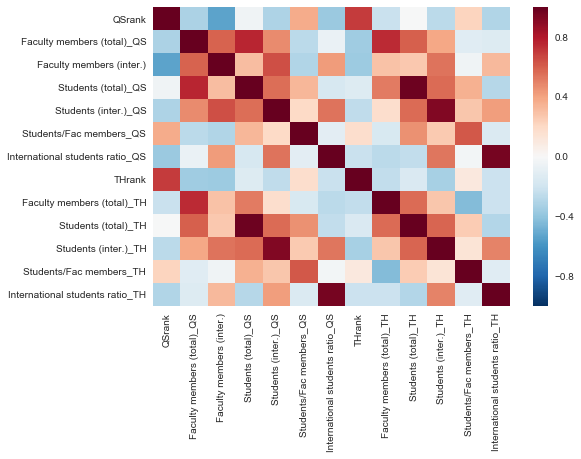

In [33]:
sns.heatmap(corr)

## Task 5: Take both rankings into account

In [36]:
merged_df = merged_df.dropna(axis = 0)
#Harmonic mean between the two rankings and sort by new rank
merged_df['Our score'] = stats.hmean([merged_df['QSrank'], merged_df['THrank']])
merged_df = merged_df.sort_values('Our score' , ascending = True)
merged_df['New rank'] = (merged_df['Our score'].rank(method = 'dense')).astype(int)
#Plotting the top 20 universities with our new ranking
merged_df[['New rank','Our score' , 'QSrank' , 'THrank']].head(20)

,New rank,Our score,QSrank,THrank
Massachusetts Institute of Technology,1,1.666667,1.0,5.0
University of Oxford,2,1.714286,6.0,1.0
Stanford University,3,2.400000,2.0,3.0
University of Cambridge,4,2.857143,5.0,2.0
California Institute of Technology,5,3.428571,4.0,3.0
Harvard University,6,4.000000,3.0,6.0
Imperial College London,7,8.000000,8.0,8.0
University of Chicago,8,9.000000,9.0,9.0
Princeton University,9,9.100000,13.0,7.0
University College London,10,9.739130,7.0,16.0


We have decided to use the harmonic to create our own ranking as it favores consistency between both rankings. This ranking sets the MIT as first. Again most universities in the top 20 are from United States.